 # Capstone Project Natural Language Processing 
 ## (Unsupervised and Supervised Learning)

In [67]:
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'Main'))
	print(os.getcwd())
except:
	pass

import nltk
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 400)
pd.set_option('float_format', '{:.2f}'.format)
import re
import codecs
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
import gensim

# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/robert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 ## Experiment Design
 Podcasts getting more and more mainstream in recent years. A lot of people are producing really good content, most of the time for free.
 But what all this has to do with NLP? If you transcribe podcast you are converting the audio into a text respresentation. From there you are able to use the regularly NLP techniques.
 In this experiment we wil use the transcript from the Tim Ferris Show: https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/
 ### Goal / Task
 1. Cluster 10 different podcast guests or styles. See if you find appropriate clusters. Create some graphs to support the analysis.
 2. Use Supervised modeling techniques to predict which podcast episode comes from which guest or style.

### Data set

#### 10 different podcast guest or styles:

 0. Tim Ferriss himself / solo (9x)
 1. RadnomShow (8x)
 2. Kevin Kelly (4x)
 3. Dom D’Agostino (3x)
 4. Tony Robins (4x)
 5. Ramit Sethi (4x)
 6. Waitzkin (4x)
 7. Sacca (3x)
 8. Peter Attias (3x)
 9. Cal Fussman (3x)
 --> 45 episodes

In [68]:
# Import raw data
# This data set contains the transcripts of The Tim Ferriss Podcasts
# Source: https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/
df = pd.read_csv("./data/tim-ferriss-podcast/thinkful.csv")
df.columns=['U', 'id', 'title', 'text']
df = df.drop(columns=['U'])
df.head()

,id,title,text
0,24,24: Random Show,"hello, ladies and gentlemen, this is tim fe..."
1,46,46: The Random Show,"hello, boys and girls, this is tim ferriss ..."
2,129,129: Random Show,"hello, boys and girls welcome to another e..."
3,146,146: Random Show,"hello, boys and girls this is tim ferriss ..."
4,171,"The Random Show – New Favorite Books, Memory T...",'he s a serial entrepreneur and world class in...


In [69]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"\\xa0", "")
    df[text_field] = df[text_field].str.replace(r"xa0", "")
    df[text_field] = df[text_field].str.replace(r" ''Tim Ferriss", "")
    df[text_field] = df[text_field].str.replace(r" n n''Tim Ferriss", "")
    df[text_field] = df[text_field].str.replace(r" n''Tim Ferriss", "")
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"show notes and links at tim blog podcast tim ferriss", "")
    df[text_field] = df[text_field].str.replace(r"copyright   2007 2018 tim ferriss  all rights reserved", "")
    return df

df['title'] = df['title'].str.replace(r"The Tim Ferriss Show Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Tim Ferriss Show Transcript: ", "")
df['title'] = df['title'].str.replace(r"Episode ", "")

df = standardize_text(df, "text")

In [70]:
# Do standard NLP processing
# Tokenize
tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["text"].apply(tokenizer.tokenize)
df.head()

# StopWords
stop_words = set(stopwords.words('english'))
df["tokens"] = df["tokens"].map(lambda x: [w for w in x if not w in stop_words])

# Remove tokens tim and ferriss
df["tokens"] = df["tokens"].map(lambda x: [w for w in x if not w == 'tim'])
df["tokens"] = df["tokens"].map(lambda x: [w for w in x if not w == 'ferriss'])

# Lemmatize
lemmer = WordNetLemmatizer()
df["tokens"] = df["tokens"].map(lambda x: [lemmer.lemmatize(w) for w in x])

# Inspecting our dataset a little more

all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max episode length is %s" % max(sentence_lengths))
print("Mean episode length is %s" % np.mean(sentence_lengths))

# Define plotting functions

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        if plot:
            x = lsa_scores[:,0]
            y = lsa_scores[:,1]
            plt.scatter(x, y, s=10, alpha=1)
            for i,label in enumerate(test_labels):
                plt.text(x[i], y[i], label, fontsize=14)


259635 words total, with a vocabulary size of 15556
Max episode length is 13088
Mean episode length is 5769.666666666667


 ## TF-IDF

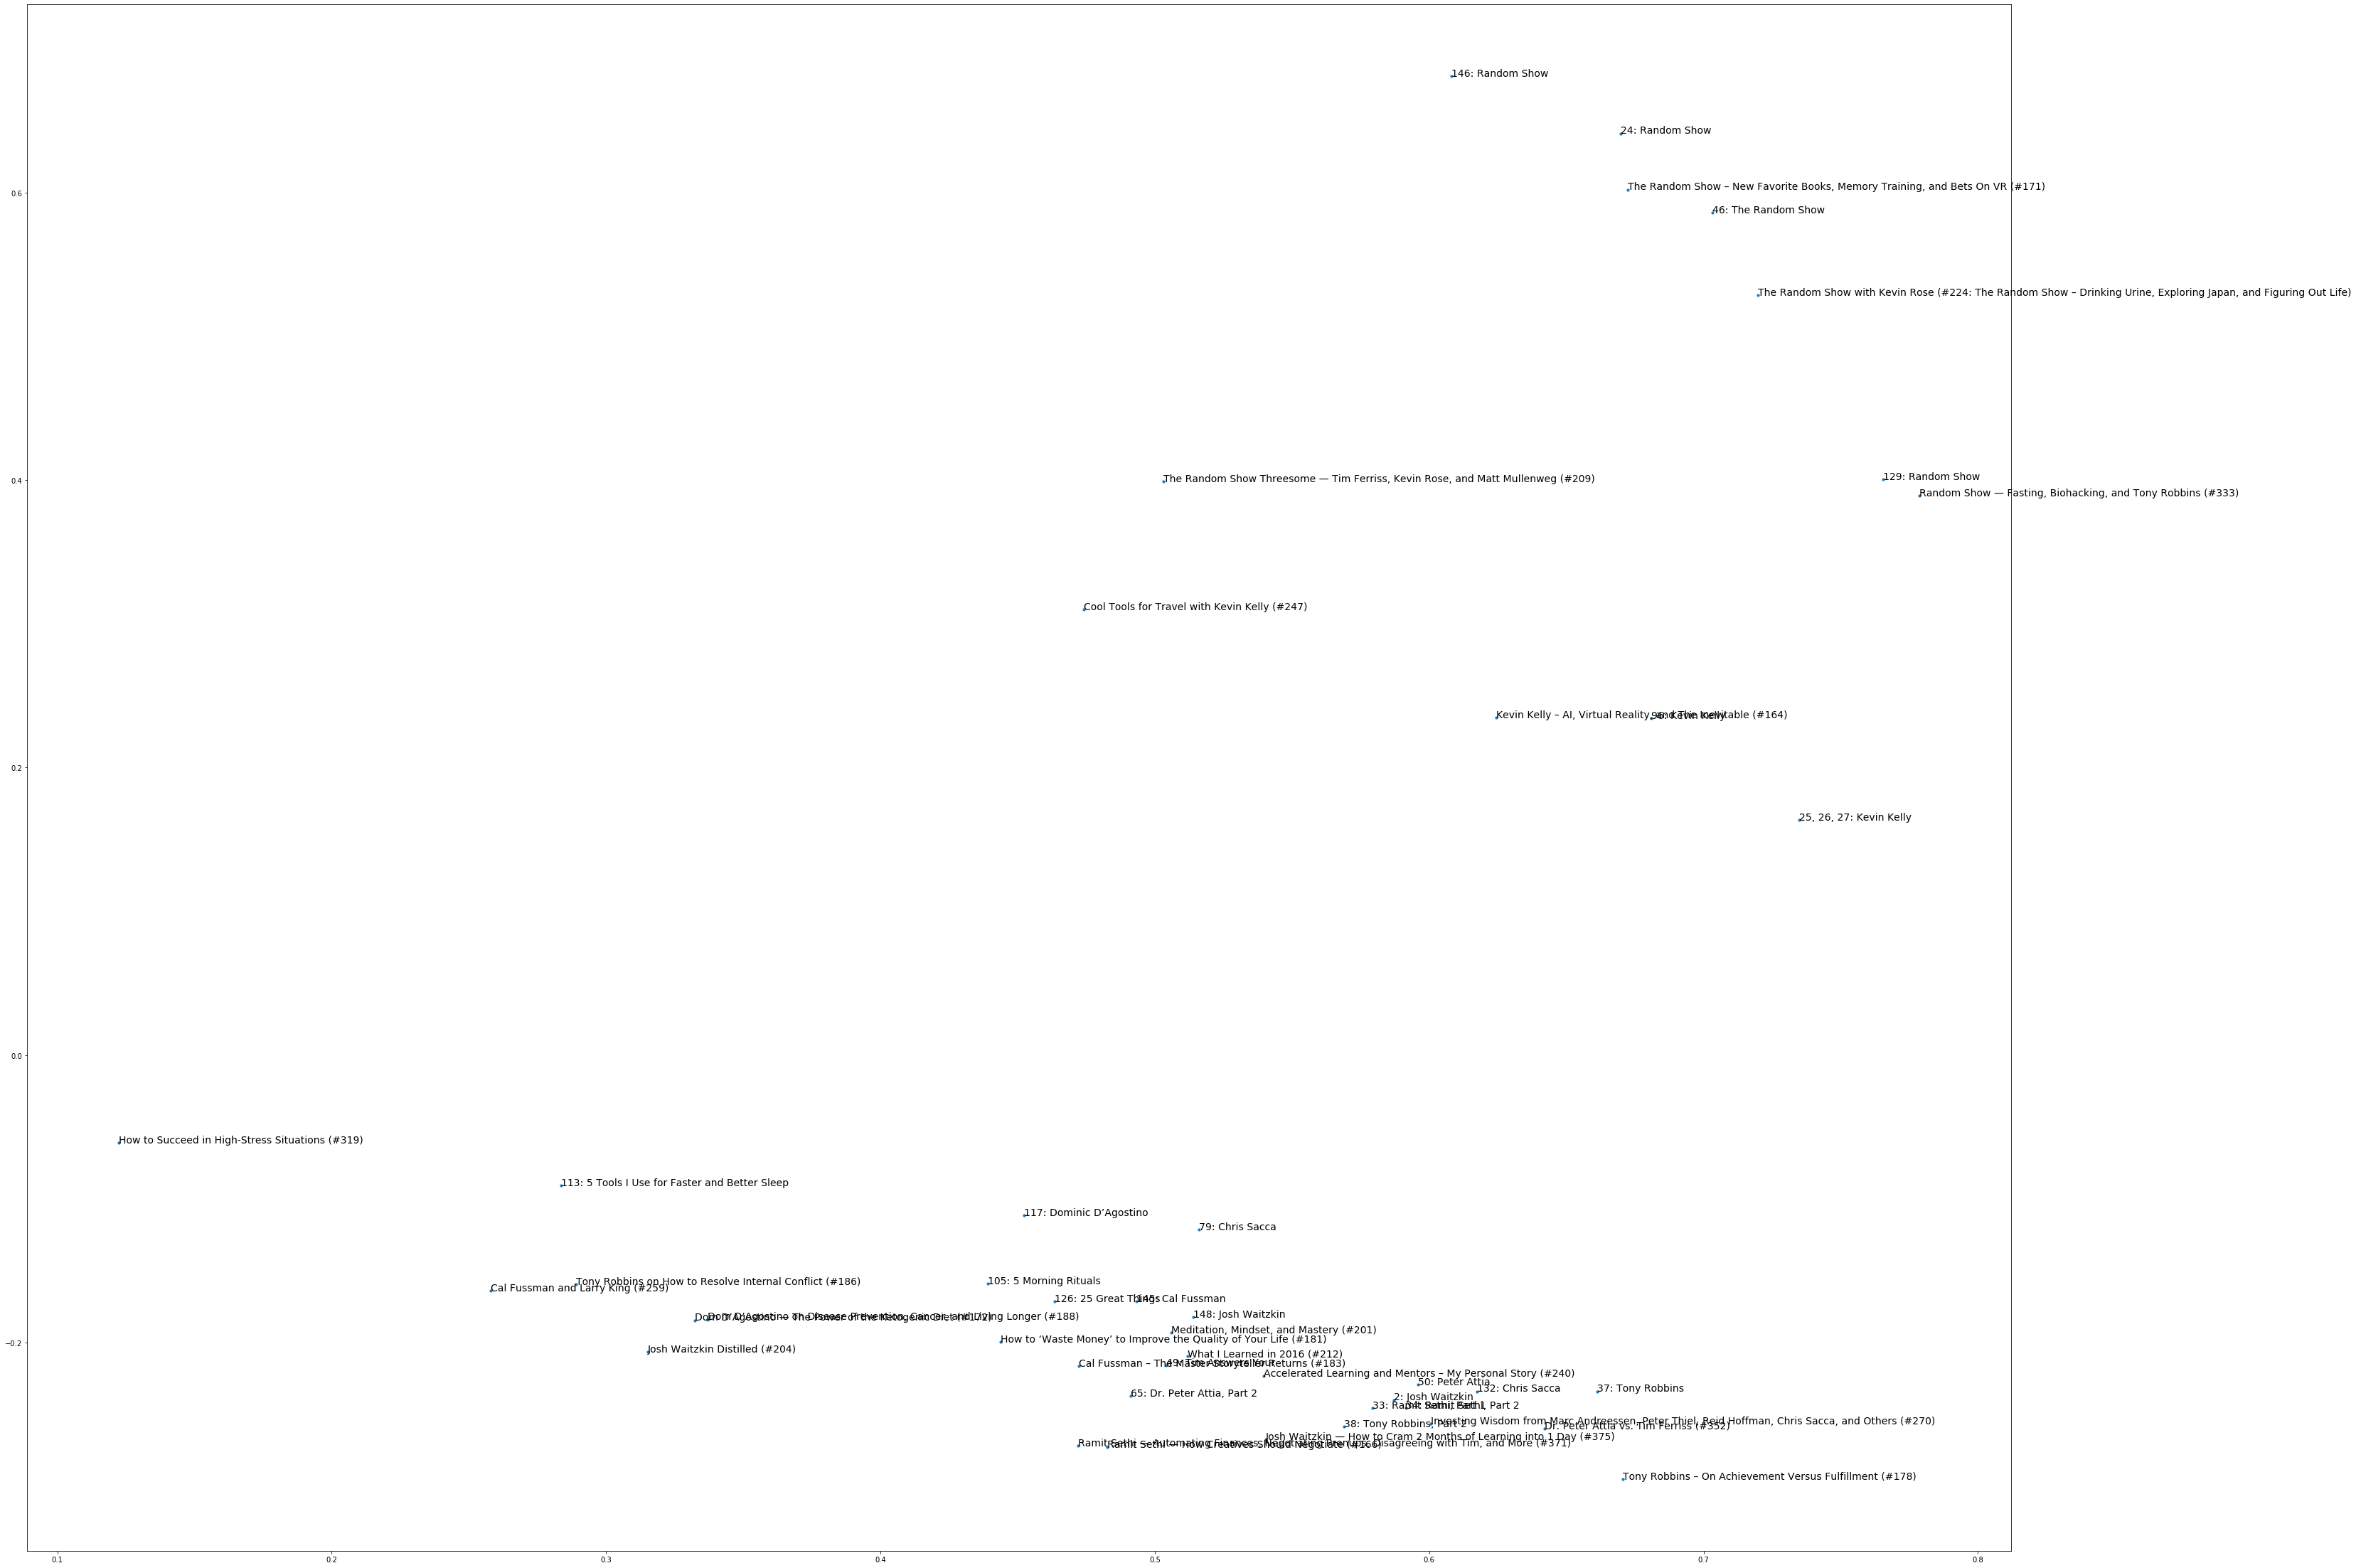

In [71]:
# Define X and the date point label
X = df["text"].tolist()
label = df["title"].tolist()     

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_tfidf, tfidf_vectorizer = tfidf(X)

# Plot TFIDF
fig = plt.figure(figsize=(50, 40))
plot_LSA(X_tfidf, label)
plt.show()


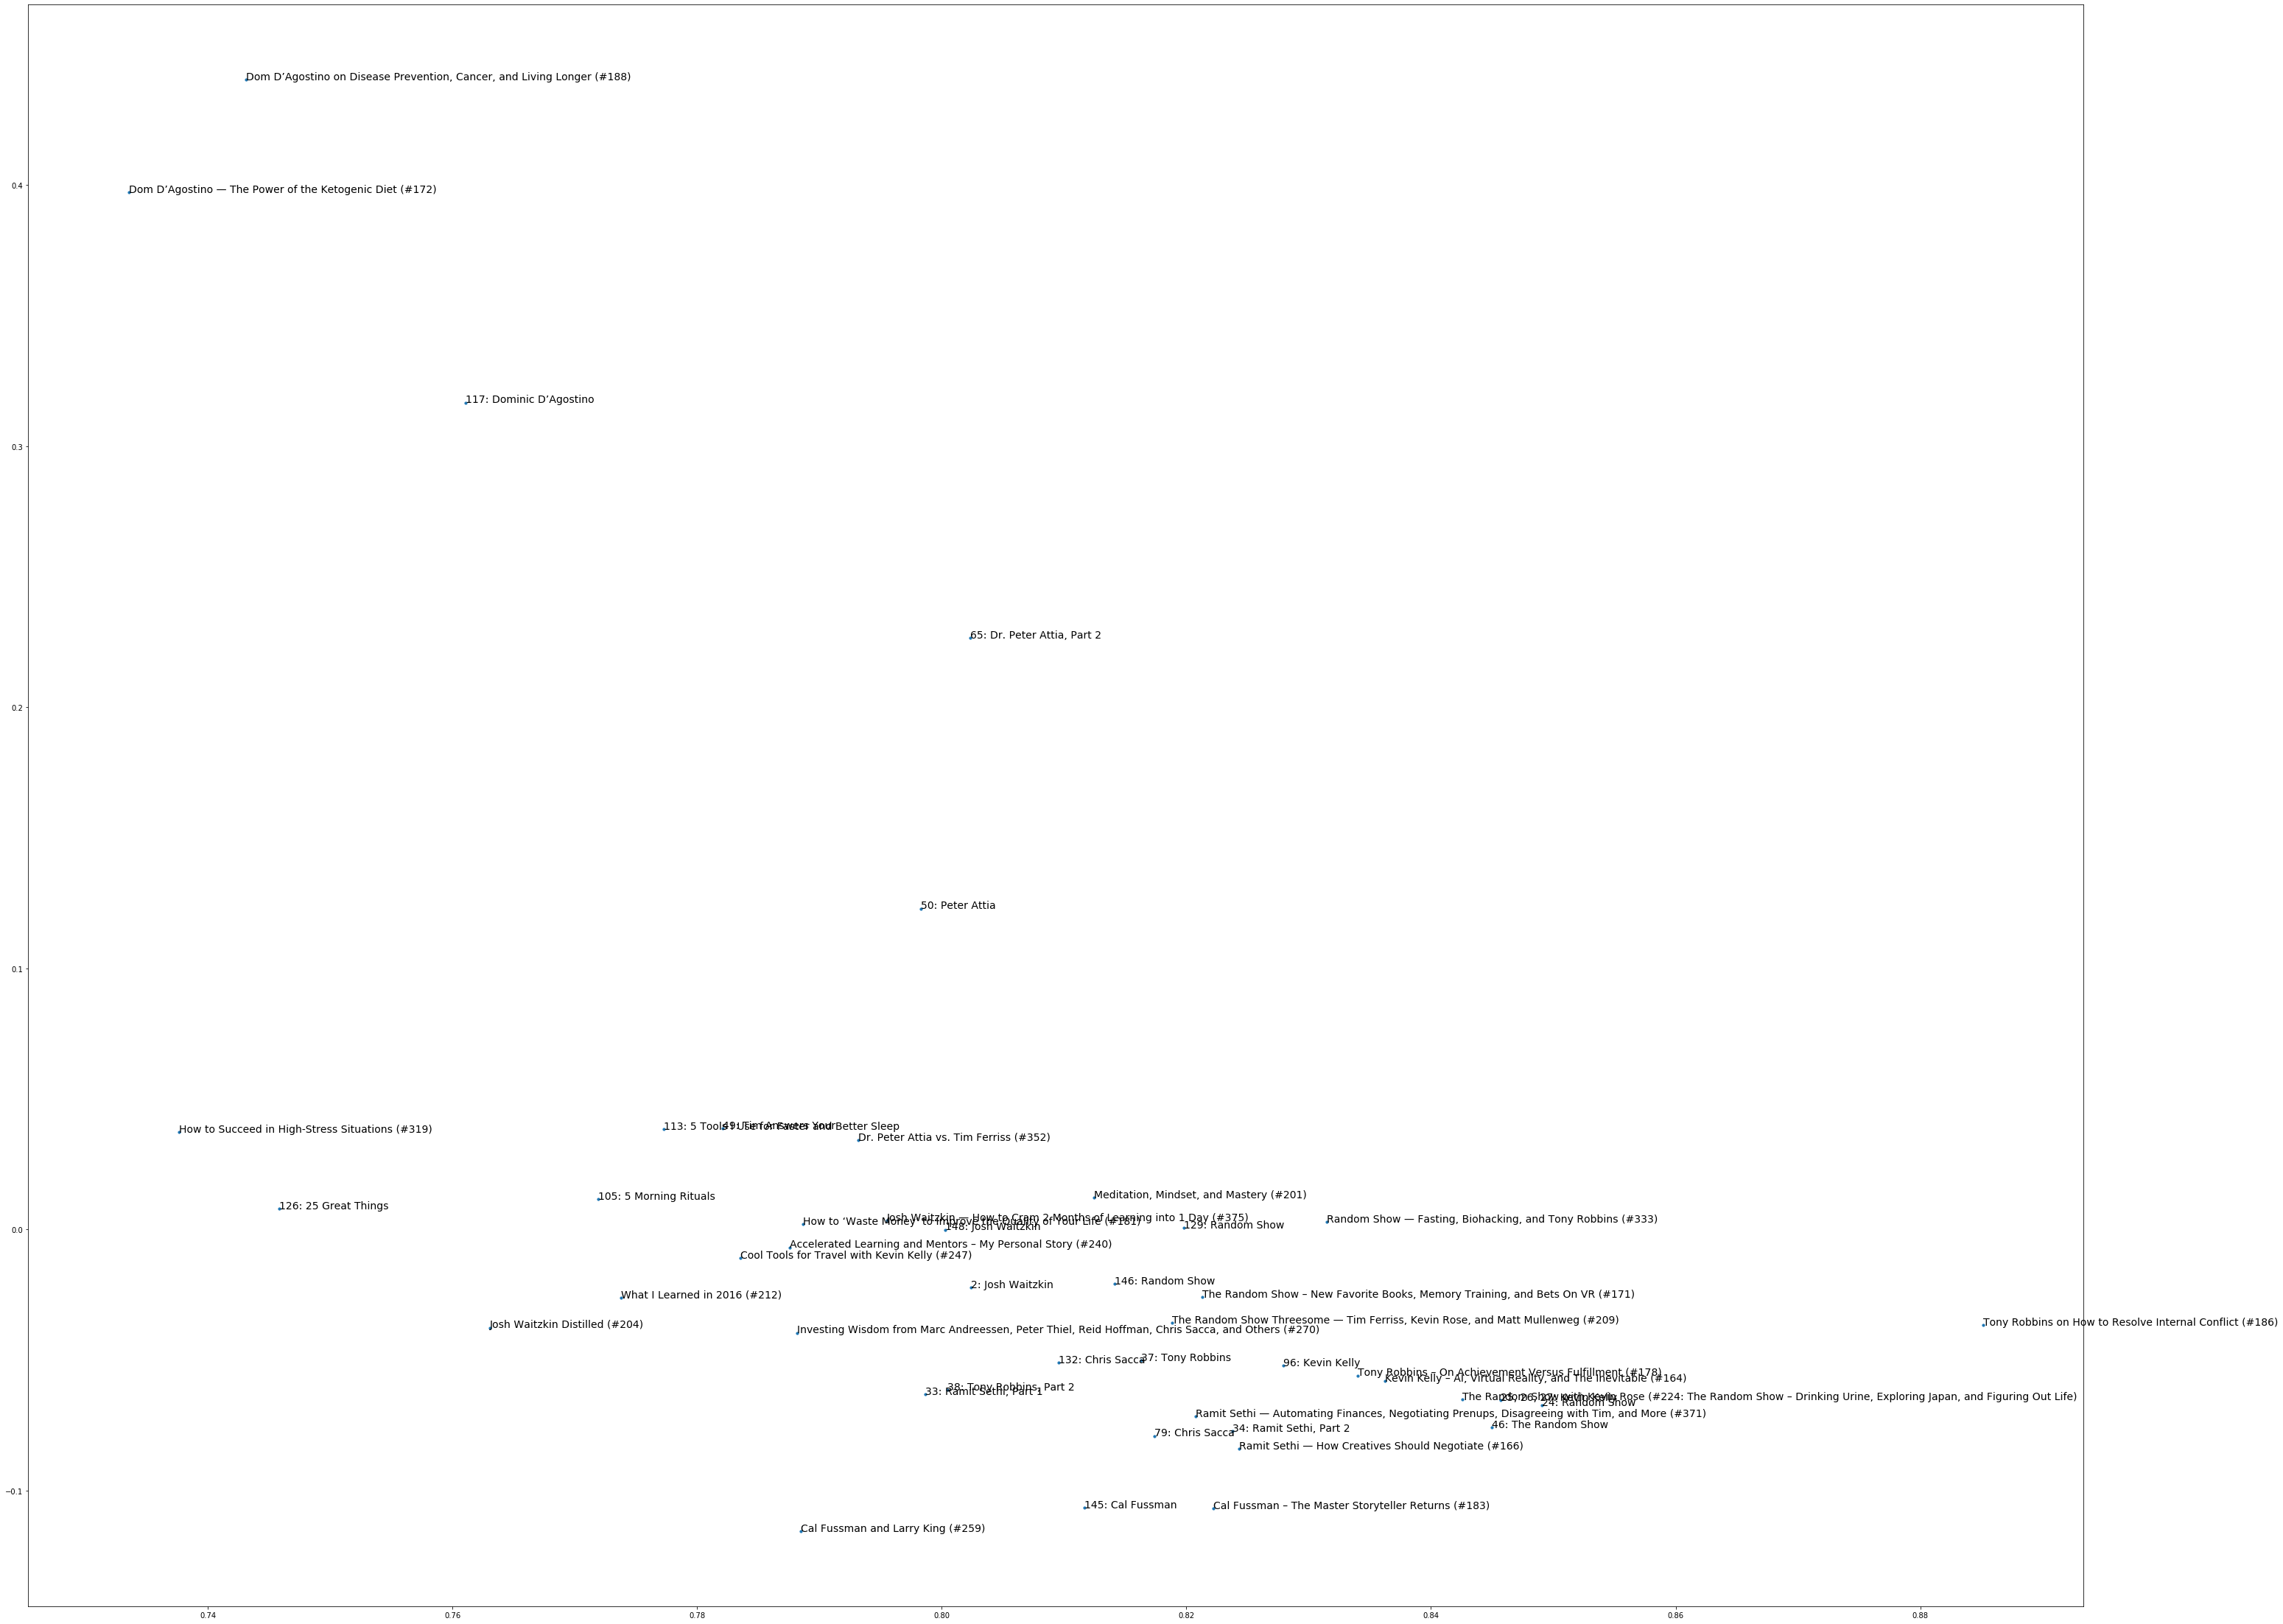

In [72]:
# Word2Vec
word2vec_path = "../../NLPofTimFerrissShow/pretrainedModels/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                    generate_missing=generate_missing))
    return list(embeddings)

embeddings = get_word2vec_embeddings(word2vec, df)

# Plot Word2Vec
fig = plt.figure(figsize=(50, 40))         
plot_LSA(embeddings, label)
plt.show()


 ## Clustering (Unsupervised)

silhouette score:  0.22739124990364523


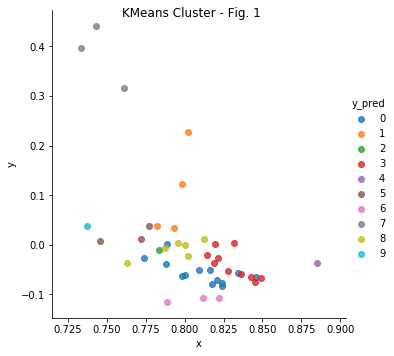

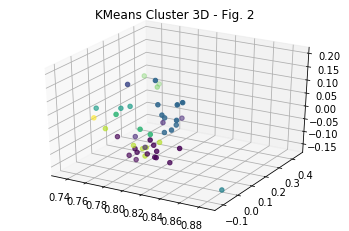

In [73]:
df_emb = pd.DataFrame(embeddings)

# Calculate predicted values.
km = KMeans(n_clusters=10, random_state=42).fit(df_emb)
y_pred = km.predict(df_emb)

print('silhouette score: ', metrics.silhouette_score(df_emb, y_pred, metric='euclidean'))

# 2D
lsa = TruncatedSVD(n_components=2)
las_results = lsa.fit_transform(df_emb.values)
las_results = pd.DataFrame(las_results, columns=['x', 'y'])

df_y = pd.DataFrame(y_pred, columns=['y_pred'])
df_y['y_pred'] = df_y['y_pred'].astype(int)

las_results = pd.concat([las_results, df_y], axis=1)

#Plot
lm = sns.lmplot(data=las_results, x='x', y='y', hue='y_pred',
                   fit_reg=False, legend=True, legend_out=True)
fig = lm.fig
fig.suptitle("KMeans Cluster - Fig. 1", fontsize=12)

# 3D
lsa = TruncatedSVD(n_components=3)
las_results = lsa.fit_transform(df_emb.values)
las_results = pd.DataFrame(las_results)

df_y = pd.DataFrame(y_pred, columns=['y_pred'])
df_y['y_pred'] = df_y['y_pred'].astype(int)

las_results = pd.concat([las_results, df_y], axis=1)

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(las_results[0].values, las_results[1].values, las_results[2].values, c=las_results['y_pred'])
ax.set_title("KMeans Cluster 3D - Fig. 2")
pyplot.show()

# Combine df with y_pred to see cluster results
results = pd.concat([df, df_y], axis=1)
results = results.drop(columns=['text'])

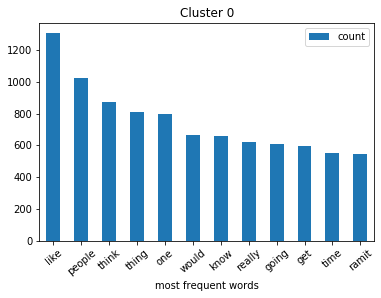

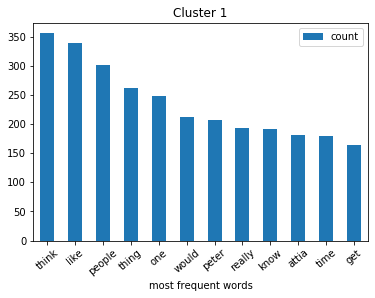

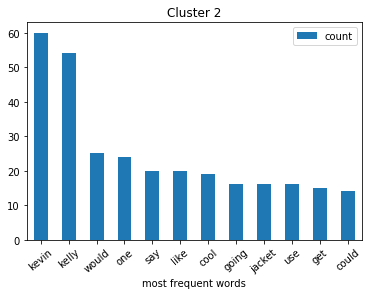

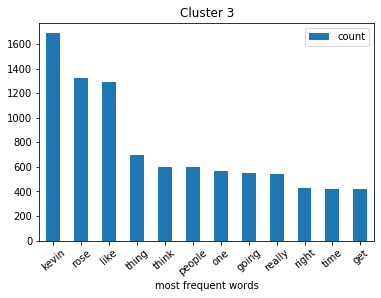

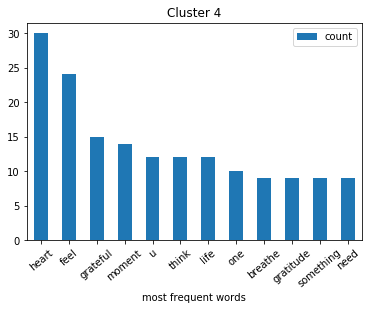

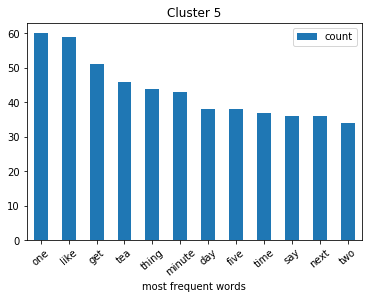

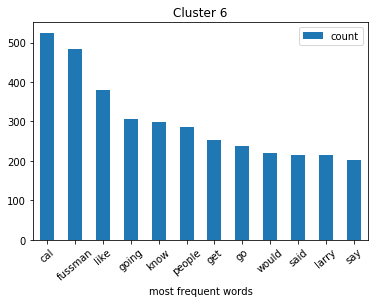

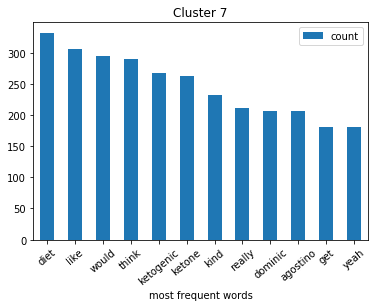

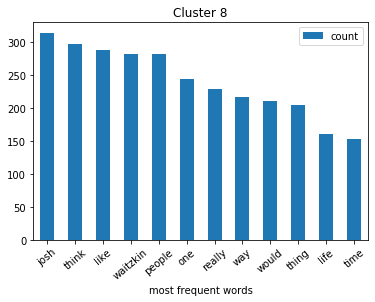

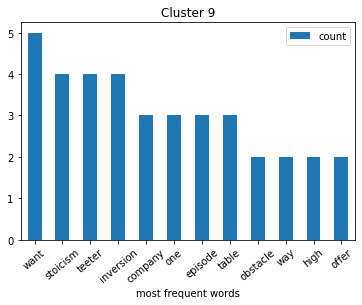

In [74]:
# Visualize cluster result
# Plot the most frequent words per cluster
for i in range(0,10,1):
    counter = Counter([word for tokens in results[results["y_pred"] == i].tokens for word in tokens]) 
    pd.DataFrame(counter.most_common(12), columns=('most frequent words', 'count')).plot.bar('most frequent words',1, title='Cluster ' + str(i))
    plt.xticks(rotation=40)
    plt.show()

In [75]:
results.drop(columns=['tokens']).sort_values('y_pred')

,id,title,y_pred
22,371,"Ramit Sethi — Automating Finances, Negotiating...",0
15,37,37: Tony Robbins,0
19,33,"33: Ramit Sethi, Part 1",0
20,34,"34: Ramit Sethi, Part 2",0
21,166,Ramit Sethi — How Creatives Should Negotiate (...,0
43,212,What I Learned in 2016 (#212),0
27,270,"Investing Wisdom from Marc Andreessen, Peter T...",0
16,38,"38: Tony Robbins, Part 2",0
8,27,"25, 26, 27: Kevin Kelly",0
29,132,132: Chris Sacca,0


 ### Findings from doing clustering:
The first four clusters are quite close to each other. The most frequent words are almost the same for each cluster.  If you take a look on the 2D plot (Fig. 1) you can see that specily the cluster __0__ and __3__ is really close to each other. So this is supporting the first finding.    
__Cluster 4__ has quite different frequent words (like grateful, feel) and showing that in this cluster the topic is way different than from the other clusters.  
__Cluster 6__ correctly identified every podcast with Cal Fussman.  
__Cluster 7__ also correctly spotted a special guest (Dominic) who is an expert in ketogenic diet. The frequent words are supporting this finding. "Diet", "Ketogenic" are one of the most frequent used words.  
__Cluster 8__ is similar to cluster 0 till 3.  
__Cluster 9__ is separated well. Also the most frequently used words are unique to compared to each other cluster.

 ## Supervised Learning Modeling

In [76]:
# Get the categories (y)
categories = pd.DataFrame(np.array([
    # Random Show
     [24,  1]
    ,[46,  1]
    ,[129, 1]
    ,[146, 1]
    ,[171, 1]
    ,[209, 1]
    ,[224, 1]
    ,[333, 1]
    # Kevin Kelly
    ,[27,  2]
    ,[96,  2]
    ,[164, 2]
    ,[247, 2]
    #Dom D’Agostino
    ,[117, 3]
    ,[172, 3]
    ,[188, 3]
    # Tony Robins 
    ,[37 , 4]
    ,[38 , 4]
    ,[178, 4]
    ,[186, 4]
    # Ramit Sethi
    ,[33,  5]
    ,[34,  5]
    ,[166, 5]
    ,[371, 5]
    # Waitzkin
    ,[2,   6]
    ,[148, 6]
    ,[204, 6]
    ,[375, 6]
    # Sacca
    ,[270, 7]
    ,[79 , 7]
    ,[132, 7]
    # Attia
    ,[50 , 8]
    ,[65 , 8]
    ,[352, 8]
    # Cal Fussman
    ,[145, 9]
    ,[183, 9]
    ,[259, 9]
    # Tim Ferriss Solo
    ,[319, 0]
    ,[49 , 0]
    ,[105, 0]
    ,[113, 0]
    ,[126, 0]
    ,[181, 0]
    ,[201, 0]
    ,[212, 0]
    ,[240, 0]
    ]),
    columns=['id', 'category'])
# Join with current dataframe "df"
df_model = pd.merge(df, categories, how='inner', on='id')

# Define X and y
X = df_model['text']
y = df_model['category']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)


In [77]:
# Use TFIDF
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Try Random Forrest
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_jobs=4, n_estimators=64)
# Fit the best algorithm to the data. 
rfc.fit(X_train_tfidf, y_train)
print('train: ', rfc.score(X_train_tfidf, y_train))
print('test: ', rfc.score(X_test_tfidf, y_test))

train:  1.0
test:  0.5


In [78]:
# Use word2vec embeddings
df_word2vec = pd.concat([df_emb, categories], axis=1)

# Define X and y
X = df_word2vec.drop(columns=['category'])
y = df_word2vec['category']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)


In [79]:
# Random Forest: 
rfc = ensemble.RandomForestClassifier(n_jobs=4)

# Choose some parameter combinations to try
parameters = {
                'n_estimators': [16, 32, 64, 96], 
                'max_features': ['log2', 'sqrt','auto'], 
                'criterion': ['entropy', 'gini'],
                'max_depth': [5, 10, 13], 
                'min_samples_split': [2, 3, 5],
                'min_samples_leaf': [1, 2, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  1.0min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [81]:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)
print('train: ', rfc.score(X_train, y_train))
print('test: ', rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
score = cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

train:  1.0
test:  0.7142857142857143
Confusion Matrix
 Predicted  0  1  2  4  6  8  9  All
True                               
0          2  0  0  0  1  0  0    3
1          0  4  0  0  0  0  0    4
2          0  0  1  0  0  0  0    1
3          0  0  0  0  0  2  0    2
4          0  0  0  1  0  1  0    2
6          0  0  0  0  1  0  0    1
9          0  0  0  0  0  0  1    1
All        2  4  1  1  2  3  1   14


ValueError: Number of classes, 8, does not match size of target_names, 10. Try specifying the labels parameter

### Findings:
Starting of with TF-IDF and RandomForrest shows a poor performance. 
With Word2Vec the performance increased significantly to 0.7. This is still poor and as the error message is showing that we even had not predicted every possible category. To fix the low performance and this error, let's create more data points. 

### Augment data
We are going to split every podcast episode text into 5 equal sized parts. This is how we augment our data set with more text pieces we can learn and predict from. 

In [82]:
df_tmp = pd.DataFrame(columns=('id', 'title', 'text', 'category'))
split = 5
for index, row in df_model.iterrows():
    text = row.text
    size = round(len(text) / split)
    text_fragments = list(map(''.join, zip(*[iter(text)]*size)))
    for text in text_fragments:
        episode_dict = dict(
            {
            'id': row.id, 
            'title': row.title,
            'text': text, 
            'category': row.category 
            }
        )
        df_tmp = df_tmp.append(pd.DataFrame(
            episode_dict, index=[0]
            ))

# Define X and y
X = df_tmp['text']
y = df_tmp['category'].astype('int')

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [84]:
# Use TFIDF
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Random Forest: 
rfc = ensemble.RandomForestClassifier(n_jobs=4, random_state=44)

# Choose some parameter combinations to try
parameters = {
                'n_estimators': [16, 32, 64, 96], 
                'max_features': ['log2', 'sqrt','auto'], 
                'criterion': ['entropy', 'gini'],
                'max_depth': [5, 10, 13], 
                'min_samples_split': [2, 3, 5],
                'min_samples_leaf': [1, 2, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X_train_tfidf, y_train)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  1.1min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=4,
                       oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

In [91]:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=13, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=4,
                       oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train_tfidf, y_train)
print('train: ', rfc.score(X_train_tfidf, y_train))
print('test: ', rfc.score(X_test_tfidf, y_test))

y_pred = rfc.predict(X_test_tfidf)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
score = cross_val_score(rfc, X_train_tfidf, y_train, cv=5, n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

train:  0.9859154929577465
test:  0.8709677419354839
Confusion Matrix
 Predicted   0  1  2  3  4  5  6  7  8  9  All
True                                         
0          14  0  0  0  0  0  0  0  0  0   14
1           0  8  0  0  0  0  0  0  0  0    8
2           1  0  3  0  0  0  0  0  0  0    4
3           0  0  0  5  0  0  0  0  0  0    5
4           3  0  0  0  2  0  0  0  0  0    5
5           0  0  0  0  0  5  0  0  0  0    5
6           2  0  0  0  0  0  5  0  0  0    7
7           2  0  0  0  0  0  0  2  0  0    4
8           0  0  0  0  0  0  0  0  4  0    4
9           0  0  0  0  0  0  0  0  0  6    6
All        22  8  3  5  2  5  5  2  4  6   62
RFC:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        14
           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RFC: Input X --> Recall: 0.712 (+/- 0.176)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


### Results
TF-IDF is working much better and has a great performance now. F1-score is much higher than the performance without data augmentation. Cross validation shows this one is a highly overfitted model.  
Let's try Word2Vec embeddings to find out if we can improve from here.

In [92]:
# Tokenize
tokenizer = RegexpTokenizer(r'\w+')

df_tmp["tokens"] = df_tmp["text"].apply(tokenizer.tokenize)
df_tmp.head()

# StopWords
stop_words = set(stopwords.words('english'))
df_tmp["tokens"] = df_tmp["tokens"].map(lambda x: [w for w in x if not w in stop_words])

# Remove tokens tim and ferriss
df_tmp["tokens"] = df_tmp["tokens"].map(lambda x: [w for w in x if not w == 'tim'])
df_tmp["tokens"] = df_tmp["tokens"].map(lambda x: [w for w in x if not w == 'ferriss'])

# Lemmatize
lemmer = WordNetLemmatizer()
df_tmp["tokens"] = df_tmp["tokens"].map(lambda x: [lemmer.lemmatize(w) for w in x])

In [93]:
embeddings = get_word2vec_embeddings(word2vec, df_tmp)
df_emb = pd.DataFrame(embeddings)

# Use word2vec embeddings
df_emb.reset_index(drop=True, inplace=True)
df_tmp.reset_index(drop=True, inplace=True)
df_word2vec = pd.concat([df_emb, df_tmp['category']], axis=1)

# Define X and y
X = df_word2vec.drop(columns=['category'])
y = df_word2vec['category'].astype(int)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [94]:
# Random Forest: 
rfc = ensemble.RandomForestClassifier(n_jobs=4, random_state=22)

# Choose some parameter combinations to try
parameters = {
                'n_estimators': [16, 32, 64, 96], 
                'max_features': ['log2', 'sqrt','auto'], 
                'criterion': ['entropy', 'gini'],
                'max_depth': [5, 6, 10, 13], 
                'min_samples_split': [2, 3, 5],
                'min_samples_leaf': [1, 2, 5]
             }

# Run the grid search
grid_obj = GridSearchCV(rfc, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  1.6min finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=4,
                       oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [95]:
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
max_depth=6, max_features='auto', max_leaf_nodes=None,
min_impurity_decrease=0.0, min_impurity_split=None,
min_samples_leaf=1, min_samples_split=5,
min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=4,
oob_score=False, random_state=22, verbose=0,
warm_start=False)

# Fit the best algorithm to the data. 
rfc.fit(X_train, y_train)
print('train: ', rfc.score(X_train, y_train))
print('test: ', rfc.score(X_test, y_test))

y_pred = rfc.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('RFC:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
score = cross_val_score(rfc, X, y, cv=5, n_jobs=-1, verbose=1)
print("RFC: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

train:  1.0
test:  0.8780487804878049
Confusion Matrix
 Predicted   0  1  2  3  4  5  6  7  8  9  All
True                                         
0          10  0  0  0  0  0  0  0  0  0   10
1           1  5  0  0  0  0  0  0  0  0    6
2           0  1  2  0  0  0  0  0  0  0    3
3           0  0  0  3  0  0  0  0  0  0    3
4           0  0  0  0  3  0  0  0  0  0    3
5           0  0  0  0  0  3  0  0  0  0    3
6           2  0  0  0  0  0  2  0  0  0    4
7           0  0  0  0  0  0  0  2  0  0    2
8           1  0  0  0  0  0  0  0  3  0    4
9           0  0  0  0  0  0  0  0  0  3    3
All        14  6  2  3  3  3  2  2  3  3   41
RFC:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.83      0.83      0.83         6
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RFC: Input X --> Recall: 0.846 (+/- 0.089)


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [56]:
for k in range(5, 25, 1):
    print('k = ', k)
    neighbors = KNeighborsClassifier(n_neighbors=k, n_jobs=-1, weights='distance')
    neighbors.fit(X_train, y_train)

    print('train: ', neighbors.score(X_train, y_train))
    print('test: ', neighbors.score(X_test, y_test))

k =  5
train:  1.0
test:  0.8048780487804879
k =  6
train:  1.0
test:  0.8048780487804879
k =  7
train:  1.0
test:  0.8048780487804879
k =  8
train:  1.0
test:  0.8048780487804879
k =  9
train:  1.0
test:  0.7073170731707317
k =  10
train:  1.0
test:  0.7317073170731707
k =  11
train:  1.0
test:  0.7073170731707317
k =  12
train:  1.0
test:  0.7073170731707317
k =  13
train:  1.0
test:  0.6585365853658537
k =  14
train:  1.0
test:  0.6829268292682927
k =  15
train:  1.0
test:  0.7317073170731707
k =  16
train:  1.0
test:  0.7317073170731707
k =  17
train:  1.0
test:  0.7317073170731707
k =  18
train:  1.0
test:  0.7317073170731707
k =  19
train:  1.0
test:  0.7073170731707317
k =  20
train:  1.0
test:  0.7317073170731707
k =  21
train:  1.0
test:  0.7560975609756098
k =  22
train:  1.0
test:  0.7560975609756098
k =  23
train:  1.0
test:  0.7560975609756098
k =  24
train:  1.0
test:  0.7560975609756098


In [57]:
neighbors = KNeighborsClassifier(n_neighbors=8, n_jobs=-1, weights='distance')
neighbors.fit(X_train, y_train)

print('train: ', neighbors.score(X_train, y_train))
print('test: ', neighbors.score(X_test, y_test))

y_pred = neighbors.predict(X_test)
print('Confusion Matrix\n', pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print('gbc:\n', classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))
score = cross_val_score(neighbors, X, y, cv=5, n_jobs=-1, verbose=1)
print("gbc: Input X --> Recall: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

train:  1.0
test:  0.8048780487804879
Confusion Matrix
 Predicted  0  1  2  3  4  5  6  7  8  9  All
True                                        
0          5  1  0  0  0  1  1  1  1  0   10
1          0  6  0  0  0  0  0  0  0  0    6
2          0  1  2  0  0  0  0  0  0  0    3
3          0  0  0  3  0  0  0  0  0  0    3
4          0  0  0  0  3  0  0  0  0  0    3
5          0  0  0  0  0  3  0  0  0  0    3
6          0  0  0  0  1  0  3  0  0  0    4
7          0  0  0  0  1  0  0  1  0  0    2
8          0  0  0  0  0  0  0  0  4  0    4
9          0  0  0  0  0  0  0  0  0  3    3
All        5  8  2  3  5  4  4  2  5  3   41
gbc:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.75      1.00      0.86         6
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       0.60      1.00      0.75         3
           5       0.75     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


 ### Findings:
 KNN has the worst performance (F1-score), even it overfits less. 
 Word2Vec embeddings with Random Forest is the winning model here. 
 There is still some overfitting but not much than TF-IDF. 

 ### Conclusion:
 Augmentation is a huge improvement and Word2Vec embeddings work the best. 